### 1. Problem Statement
The fatigue dataset has the chemical composition, process condition and fatigue strength of metals. The goal of this project is to predict fatigue strength based on chemical composition and process condition.

Success will be measured with r2 score and the objective is to get a r2 score > 0.9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### 2. Data extraction


* Chemical Composition
Abbr. | Details 
:-----| :------------------------
C     | % Carbon 
Si    | % Silicon 
Mn    | % Manganese 
P     | % Phosphorus
S     | % Sulphur
Ni    | % Nickel
Cr    | % Chromlum
Cu    | % Copper
Mo    | % Molybdenum


* Heat Treatment Condition
Abbr. | Details 
:-----| :------------------------
NT    | Nomalizing Temperature
THT   | Through Hardening Temperature
THt   | Through Hardening Time
THQCr | Cooling Rate for Through Hardening
CT    | Carburization Temperature
Ct    | Carburization Time
DT    | Diffusion Temperature
Dt    | Diffusion Time
QmT   | Quenching Media Temperature (for Carburization)
TT    | Tempering Temperature
Tt    | Tempering Time
TCr   | Cooling Rate for Tempering

* Upstream Processing Condition
Abbr. | Details 
:--------|:------------------------
RedRatio | Reduction Ratio (Ingot to Bar)
dA       | Area Proportion of Inclusions Deformed by Plastic Work
dB       | Area Proportion of Inclusions Occuring in Discontinuous Array
dC       | Area Proportion of Isolated Inclusions


* Target
Fatigue: Rotating Bending Fatigue Strength (10^7 cycles)

In [2]:
data_set = pd.read_excel("Fatigue.xlsx")

In [3]:
data_set.head()

,Class,NT,THT,THt,THQCr,CT,Ct,DT,Dt,QmT,...,S,Ni,Cr,Cu,Mo,RedRatio,dA,dB,dC,Fatigue
0,Carbon_low_alloy,885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022,0.01,0.02,0.01,0.0,825,0.07,0.02,0.04,232
1,Carbon_low_alloy,885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017,0.08,0.12,0.08,0.0,610,0.11,0.00,0.04,235
2,Carbon_low_alloy,885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015,0.02,0.03,0.01,0.0,1270,0.07,0.02,0.00,235
3,Carbon_low_alloy,885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.024,0.01,0.02,0.01,0.0,1740,0.06,0.00,0.00,241
4,Carbon_low_alloy,885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022,0.01,0.02,0.02,0.0,825,0.04,0.02,0.00,225


In [4]:
data_set['Class'].value_counts()

Carbon_low_alloy    371
Carburizing          48
Spring               18
Name: Class, dtype: int64

In [5]:
# split in train and test
#from sklearn.model_selection import train_test_split

#train_set, test_set = train_test_split(data_set, test_size=0.2, random_state=42)
#data_set = train_set

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_set, data_set["Class"]):
    strat_train_set = data_set.loc[train_index]
    strat_test_set = data_set.loc[test_index]

In [6]:
strat_train_set['Class'].value_counts() / len(strat_train_set)

Carbon_low_alloy    0.848138
Carburizing         0.108883
Spring              0.042980
Name: Class, dtype: float64

In [7]:
strat_test_set["Class"].value_counts() / len(strat_test_set)

Carbon_low_alloy    0.852273
Carburizing         0.113636
Spring              0.034091
Name: Class, dtype: float64

In [8]:
# make a copy for EDA
data_set = strat_train_set.copy()

In [9]:
# prepara data for ML algorithms
X_train = strat_train_set.drop(columns=["Fatigue"], axis=1) 
y_train = strat_train_set["Fatigue"]

X_test = strat_test_set.drop(columns=["Fatigue"], axis=1) 
y_test = strat_test_set["Fatigue"]

X_train.shape, X_test.shape

((349, 26), (88, 26))

### 3. Exploratory Data Analysis

- Data Shape
- Data Types
- Target variable
- Missing Values
- Constant features
- Cardinality
- Duplicate features
- Correlations
- Scale
- Distributions (skewness)
- Outliers

In [10]:
data_set.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 10 to 3
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Class     349 non-null    object 
 1   NT        349 non-null    int64  
 2   THT       301 non-null    float64
 3   THt       301 non-null    float64
 4   THQCr     301 non-null    float64
 5   CT        38 non-null     float64
 6   Ct        38 non-null     float64
 7   DT        38 non-null     float64
 8   Dt        38 non-null     float64
 9   QmT       38 non-null     float64
 10  TT        339 non-null    float64
 11  Tt        339 non-null    float64
 12  TCr       339 non-null    float64
 13  C         349 non-null    float64
 14  Si        349 non-null    float64
 15  Mn        349 non-null    float64
 16  P         349 non-null    float64
 17  S         349 non-null    float64
 18  Ni        349 non-null    float64
 19  Cr        349 non-null    float64
 20  Cu        349 non-null    float64

###### This dataset has:
- 27 features, 1 categorical variable and 26 numerical variables
- 349 observations
- There are missing values in processing parameters
- The target variable is ['Fatigue']

Class | Normalizing | Hardening | Carburizing | Tempering
:--------|:-------------|:-------|:-------|:-------
Carbon_low_alloy | Yes | Maybe | No | Maybe
Carburizing      | Yes | No | Yes | Yes
Spring       | Yes | Yes | No | Yes


In [11]:
data_set.isnull().mean().sort_values(ascending=False)

QmT         0.891117
CT          0.891117
Ct          0.891117
DT          0.891117
Dt          0.891117
THT         0.137536
THt         0.137536
THQCr       0.137536
TT          0.028653
Tt          0.028653
TCr         0.028653
dA          0.000000
Mo          0.000000
RedRatio    0.000000
Class       0.000000
dB          0.000000
dC          0.000000
Cr          0.000000
Cu          0.000000
C           0.000000
Ni          0.000000
S           0.000000
P           0.000000
Mn          0.000000
Si          0.000000
NT          0.000000
Fatigue     0.000000
dtype: float64

- Carburization parameters (['CT'], ['Ct'], ['DT'], ['Dt'], [QmT]) have 89.11% missing values
- Hardening parameters (['THT'], ['THt'], ['THQCr'] have 13.75% missing values
- Temperring parameters (['TT'], ['Tt'], ['TCr']) have 2.87% missing values
- Need to impute missing values

In [12]:
#constant features
tab = data_set.nunique().sort_values(ascending=False)
tab

Fatigue     218
Cr           64
Mn           54
Ni           42
C            40
RedRatio     34
Si           26
S            26
P            24
Cu           21
dA           21
Mo           15
TT           12
Ct           11
dC           10
dB            7
NT            7
DT            6
Dt            6
THT           4
Class         3
THQCr         2
TCr           2
Tt            2
QmT           2
THt           1
CT            1
dtype: int64

This dataset has:

- 2 constant features: ['THt'] and ['CT'], missing values will be imputed 

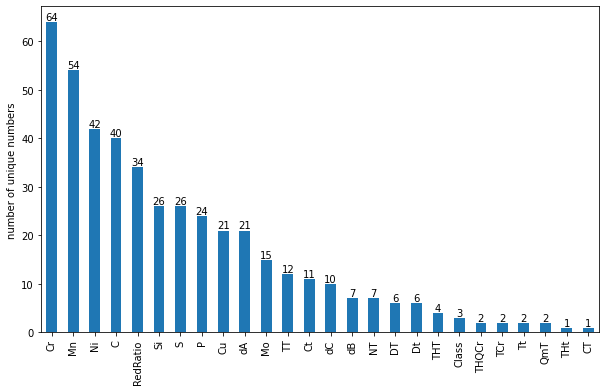

In [13]:
plt.figure(figsize=[10,6])
ax = tab[1::].plot.bar()
ax.bar_label(ax.containers[0])
plt.ylabel('number of unique numbers')
plt.show()

[Text(0, 0, '296'), Text(0, 0, '38'), Text(0, 0, '15')]

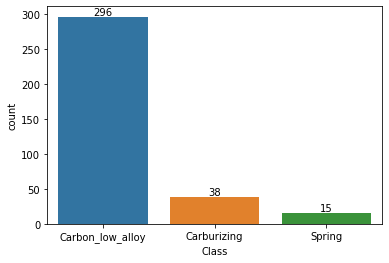

In [14]:
#categorical 
ax = sns.countplot(x=data_set['Class'])
ax.bar_label(ax.containers[0])

<AxesSubplot:xlabel='Fatigue', ylabel='Count'>

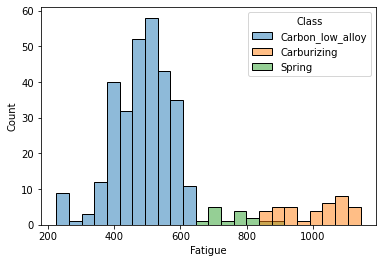

In [15]:
#fatigue vs. class
sns.histplot(data=data_set, x='Fatigue', hue='Class')

In [16]:
# classify feature columns
col_chem = ['C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Cu', 'Mo']
col_upstream = ['dA', 'dB', 'dC', 'RedRatio']
col_time = ['THt', 'Ct', 'Dt', 'Tt']
col_temp = ['NT', 'THT', 'CT', 'DT', 'QmT', 'TT']
col_cool = ['THQCr', 'TCr']

In [17]:
# high level statistics for numerical variables
data_set.describe()

,NT,THT,THt,THQCr,CT,Ct,DT,Dt,QmT,TT,...,S,Ni,Cr,Cu,Mo,RedRatio,dA,dB,dC,Fatigue
count,349.000000,301.000000,301.0,301.000000,38.0,38.000000,38.000000,38.000000,38.000000,339.000000,...,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,872.578797,848.388704,30.0,12.305648,930.0,369.457895,883.844184,46.484211,78.947368,549.174041,...,0.014699,0.509713,0.574756,0.068052,0.068596,908.782235,0.047246,0.003593,0.007685,552.166189
std,26.021050,9.651169,0.0,7.107714,0.0,160.859676,19.678853,22.878274,34.468119,143.930135,...,0.006350,0.857790,0.416459,0.049956,0.087976,499.674571,0.030765,0.008320,0.010453,187.357796
min,825.000000,825.000000,30.0,8.000000,930.0,90.000000,850.000000,15.000000,60.000000,160.000000,...,0.003000,0.010000,0.010000,0.010000,0.000000,240.000000,0.000000,0.000000,0.000000,225.000000
25%,865.000000,845.000000,30.0,8.000000,930.0,340.200000,881.807000,27.600000,60.000000,550.000000,...,0.009000,0.020000,0.120000,0.020000,0.000000,590.000000,0.020000,0.000000,0.000000,443.000000
50%,870.000000,845.000000,30.0,8.000000,930.0,450.000000,895.517000,47.400000,60.000000,600.000000,...,0.015000,0.050000,0.720000,0.060000,0.000000,740.000000,0.040000,0.000000,0.004000,510.000000
75%,870.000000,855.000000,30.0,24.000000,930.0,499.800000,895.812000,70.200000,60.000000,650.000000,...,0.019000,0.240000,0.990000,0.100000,0.170000,1228.000000,0.070000,0.000000,0.010000,578.000000
max,930.000000,865.000000,30.0,24.000000,930.0,540.000000,903.333000,70.200000,140.000000,680.000000,...,0.030000,2.780000,1.170000,0.260000,0.240000,5530.000000,0.130000,0.050000,0.058000,1144.000000


In [18]:
# Distributions only (for outliers, values further away from zero indicate more extreme outliers) 
sk = data_set.skew().sort_values(key=lambda x:-abs(x))

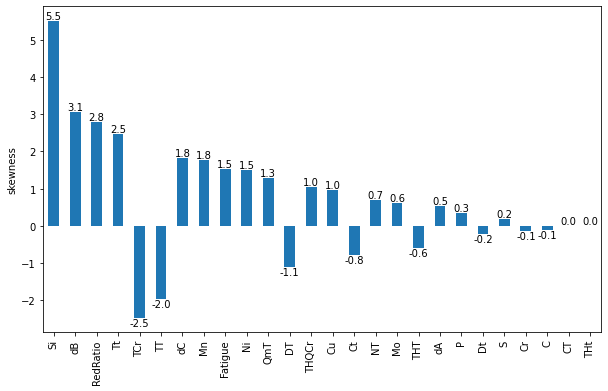

In [19]:
plt.figure(figsize=[10,6])
ax = sk.plot.bar()
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.ylabel('skewness')
plt.show()

- skewness [-0.5, 0.5] -> fairly symmetrical
- skewness [-1, -0.5] or [0.5, 1], moderately skewed
- skewness <-1 or >1, highly skewed

* Positive Skew: mean>median, right tail
* Negative Skew: mean<median, left tail

In [20]:
# Distributions
d = {'mean': data_set.select_dtypes(exclude=['object']).mean(),
     'median': data_set.select_dtypes(exclude=['object']).median(),
     'min': data_set.select_dtypes(exclude=['object']).min(),
     'max': data_set.select_dtypes(exclude=['object']).max(),
     'skew': data_set.select_dtypes(exclude=['object']).skew()}

skew_tb = pd.DataFrame(d)
skew_tb.sort_values(by='skew', key=lambda x:-abs(x))

,mean,median,min,max,skew
Si,0.307307,0.260,0.160,2.050,5.508137
dB,0.003593,0.000,0.000,0.050,3.058511
RedRatio,908.782235,740.000,240.000,5530.000,2.781942
Tt,66.725664,60.000,60.000,120.000,2.470069
TCr,21.365782,24.000,0.500,24.000,-2.470069
TT,549.174041,600.000,160.000,680.000,-1.971633
dC,0.007685,0.004,0.000,0.058,1.824341
Mn,0.819943,0.760,0.370,1.600,1.757980
Fatigue,552.166189,510.000,225.000,1144.000,1.528103
Ni,0.509713,0.050,0.010,2.780,1.505830


- right tail (postitive skewness): ['Si'], ['dB'], ['RedRatio'], ['Tt'], ['dC'], ['Mn'], ['Fatigue'],['Ni'],  ['QmT'], ['THQCr']
- left tail (negative skewness): ['TCr'], ['TT'], ['DT']
- 4 order of magnitude: ['RedRatio'], ['Fatigue']
- 3 order of magnitude: ['NT'], ['THT'], ['CT'], ['Ct'], ['DT'], ['QmT'], ['TT'], ['Tt']
- 2 order of magnitude: ['THt'], ['THQCr'], ['Dt'], ['TCr']
- 1 order of magnitude: ['C'], ['Si'], ['Mn'], ['P'], ['S'], ['Ni'], ['Cr'], ['Cu'], ['Mo'], ['dA'], ['dB'], ['dC']
- scaling is required

[Text(0.5, 0, 'RedRatio')]

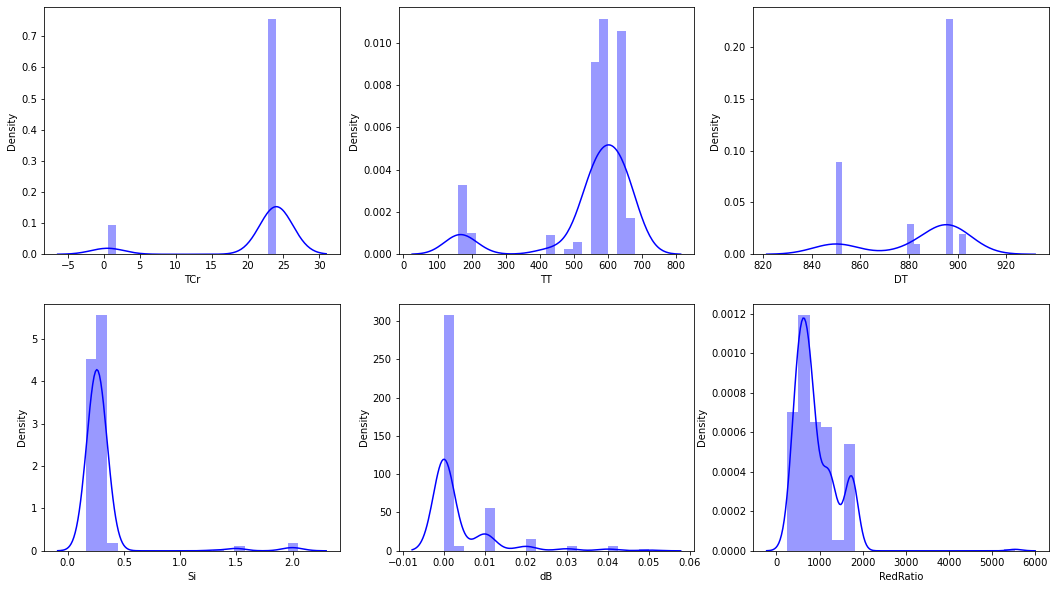

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#left tail
ax = sns.distplot(ax=axes[0, 0], x=data_set['TCr'], bins=20, color="blue")
ax.set(xlabel='TCr')
ax = sns.distplot(ax=axes[0, 1], x=data_set['TT'], bins=20, color="blue")
ax.set(xlabel='TT')
ax = sns.distplot(ax=axes[0, 2], x=data_set['DT'], bins=20, color="blue")
ax.set(xlabel='DT')
#right tail
ax = sns.distplot(ax=axes[1, 0], x=data_set['Si'], bins=20, color="blue")
ax.set(xlabel='Si')
ax = sns.distplot(ax=axes[1, 1], x=data_set['dB'], bins=20, color="blue")
ax.set(xlabel='dB')
ax = sns.distplot(ax=axes[1, 2], x=data_set['RedRatio'], bins=20, color="blue")
ax.set(xlabel='RedRatio')

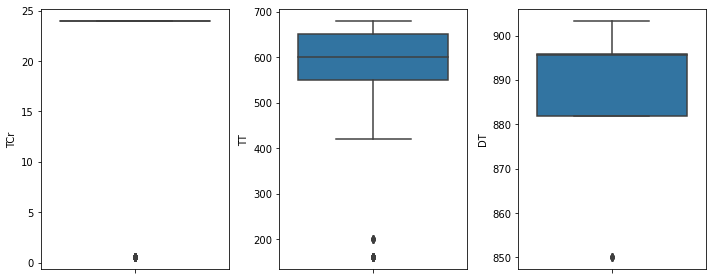

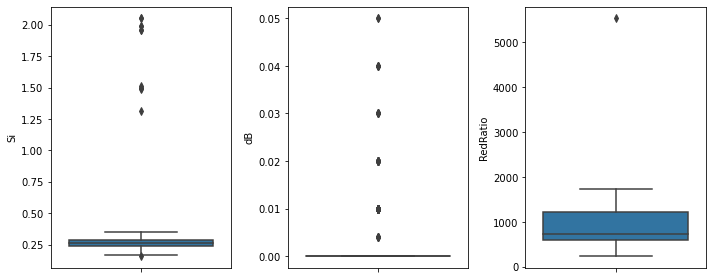

In [22]:
# Box plot
num_cols = ['TCr', 'TT', 'DT', 'Si', 'dB', 'RedRatio']
facet = None
for i in range(0, len(num_cols), 3):
    plt.figure(figsize=(10,4))
    plt.subplot(131)
    sns.boxplot(y=data_set[num_cols[i]])
    plt.subplot(132)
    sns.boxplot(y=data_set[num_cols[i+1]])
    plt.subplot(133)
    sns.boxplot(y=data_set[num_cols[i+2]])
    plt.tight_layout()
    plt.show()

<AxesSubplot:>

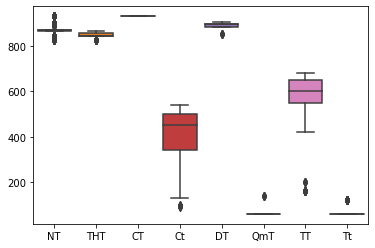

In [23]:
# boxplot 
sns.boxplot(data=data_set[['NT','THT','CT','Ct','DT','QmT','TT','Tt']])

<AxesSubplot:>

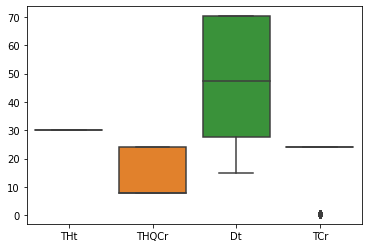

In [24]:
# boxplot 
sns.boxplot(data=data_set[['THt','THQCr','Dt','TCr']])

<AxesSubplot:>

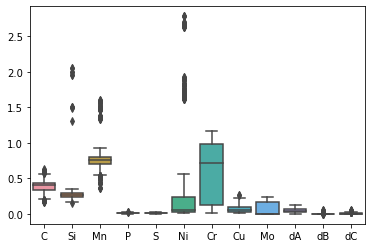

In [25]:
# boxplot 
sns.boxplot(data=data_set[ ['C','Si','Mn','P','S','Ni','Cr','Cu','Mo','dA','dB','dC']])

<AxesSubplot:>

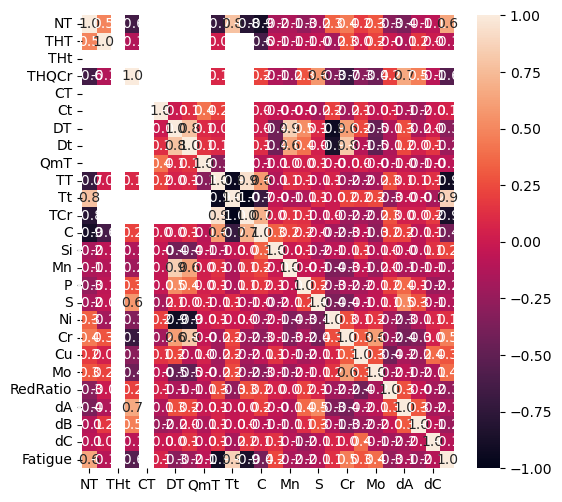

In [26]:
plt.figure(figsize=(6,6), dpi=100)
sns.heatmap(data_set.corr(), annot=True, fmt=".1f")

<AxesSubplot:>

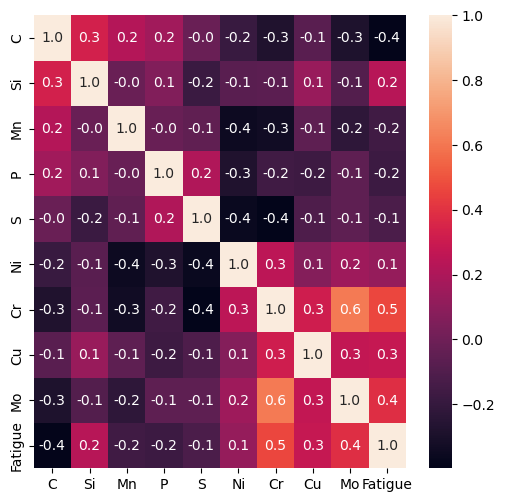

In [27]:
plt.figure(figsize=(6,6), dpi=100)
sns.heatmap(data_set[col_chem+['Fatigue']].corr(), annot=True, fmt=".1f")

<AxesSubplot:>

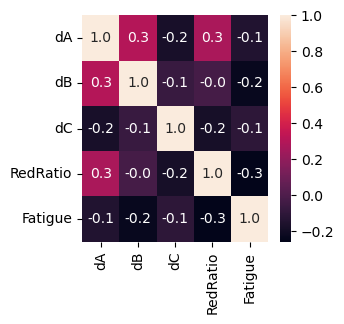

In [28]:
plt.figure(figsize=(3,3), dpi=100)
sns.heatmap(data_set[col_upstream+['Fatigue']].corr(), annot=True, fmt=".1f")

<AxesSubplot:>

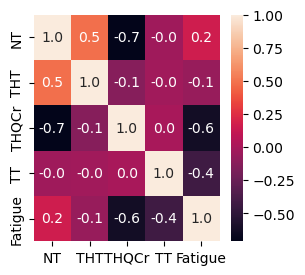

In [29]:
#col_time = ['THt', 'Ct', 'Dt', 'Tt']
#col_temp = ['NT', 'THT', 'CT', 'DT', 'QmT', 'TT']
#col_cool = ['THQCr', 'TCr']
#class0_corr = data_set[data_set['Class']=='Carbon_low_alloy'][['NT', 'THt', 'THT', 'THQCr', 'TT', 'Tt', 'TCr', 'Fatigue']].corr()
class0_corr = data_set[data_set['Class']=='Carbon_low_alloy'][['NT', 'THT', 'THQCr', 'TT', 'Fatigue']].corr()
plt.figure(figsize=(3,3), dpi=100)
sns.heatmap(class0_corr, annot=True, fmt=".1f")

<AxesSubplot:>

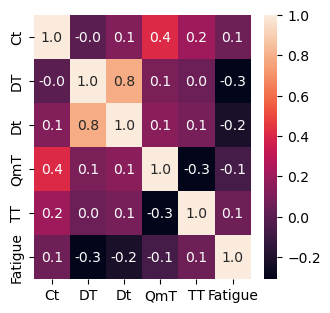

In [30]:
#class1_corr = data_set[data_set['Class']=='Carburizing'][['NT', 'CT', 'Ct', 'DT', 'Dt', 'QmT', 'TT', 'Tt', 'TCr','Fatigue']].corr()
class1_corr = data_set[data_set['Class']=='Carburizing'][['Ct', 'DT', 'Dt', 'QmT', 'TT','Fatigue']].corr()
plt.figure(figsize=(3.5,3.5), dpi=100)
sns.heatmap(class1_corr, annot=True, fmt=".1f")

<AxesSubplot:>

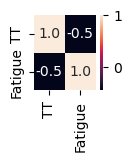

In [31]:
class2_corr = data_set[data_set['Class']=='Spring'][['TT','Fatigue']].corr()
plt.figure(figsize=(1,1), dpi=100)
sns.heatmap(class2_corr, annot=True, fmt=".1f")

In [32]:
#missing value handling
data_set2 = data_set.copy()
data_set2[col_time] = data_set[col_time].fillna(0)
data_set2[col_temp] = data_set[col_temp].fillna(data_set[col_temp].median())
data_set2[col_cool] = data_set[col_cool].fillna(data_set[col_cool].median())

In [33]:
data_set2.nunique().sort_values(ascending=False)

Fatigue     218
Cr           64
Mn           54
Ni           42
C            40
RedRatio     34
Si           26
S            26
P            24
Cu           21
dA           21
Mo           15
TT           12
Ct           12
dC           10
Dt            7
dB            7
NT            7
DT            6
THT           4
Class         3
Tt            3
THt           2
THQCr         2
TCr           2
QmT           2
CT            1
dtype: int64

In [34]:
#drop constant and categorical variables
data_set2.drop(columns=['CT', 'Class'], inplace=True)

In [35]:
col_temp2 = col_temp.copy()
col_temp2.remove('CT')

<AxesSubplot:>

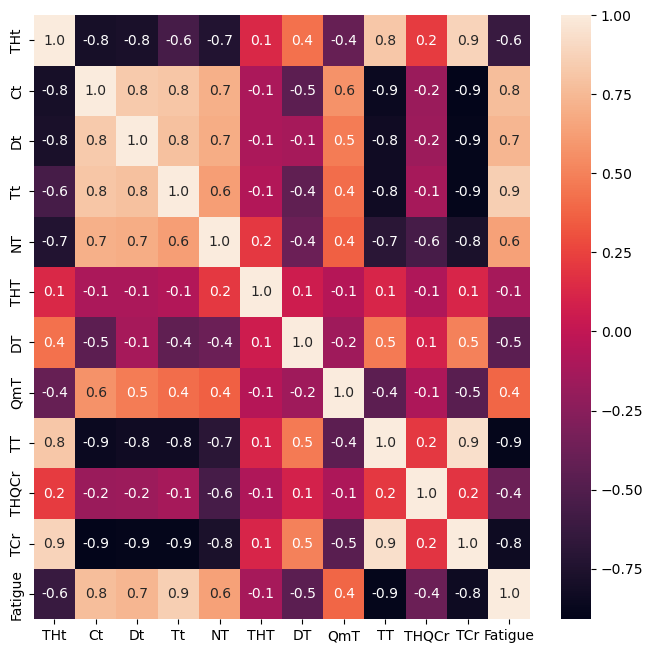

In [36]:
plt.figure(figsize=(8,8), dpi=100)
sns.heatmap(data_set2[col_time+col_temp2+col_cool+['Fatigue']].corr(), annot=True, fmt=".1f")

<AxesSubplot:>

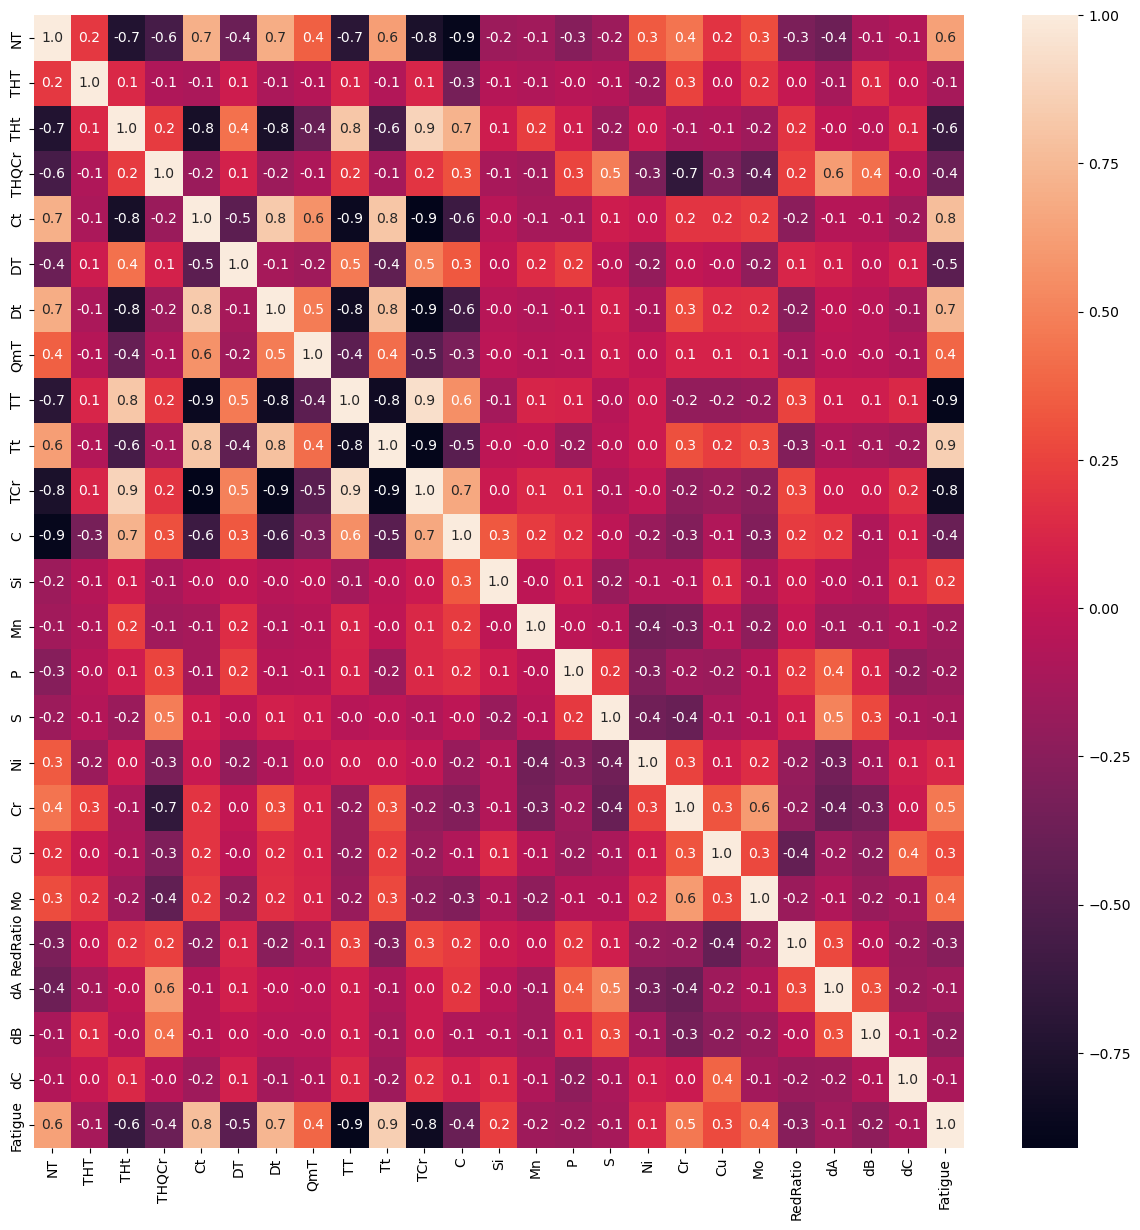

In [37]:
plt.figure(figsize=(15,15), dpi=100)
sns.heatmap(data_set2.corr(), annot=True, fmt=".1f")

- There are many features have correlation > 0.9, which can be dropped. 

In [39]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print("-------------------------")
print(get_top_abs_correlations(data_set2.drop(columns=["Fatigue"]), 5))

Top Absolute Correlations
-------------------------
TT  TCr    0.938947
Ct  TCr    0.910170
Dt  TCr    0.889221
Tt  TCr    0.887956
NT  C      0.884862
dtype: float64


- Processing parameters are more relevant
- Chemical compositions and reduction ratio are less relevant
- The most relevant chemical compositions are Cr, C and Mo

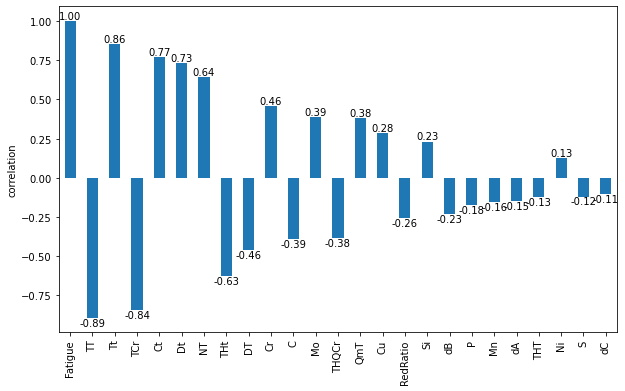

In [38]:
# Correlation with target variable
cor_ordered = data_set2.corr(method='pearson')['Fatigue'].sort_values(key=lambda x:-abs(x))

plt.figure(figsize=[10,6])
ax = cor_ordered.plot.bar()
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.ylabel('correlation')
plt.show()

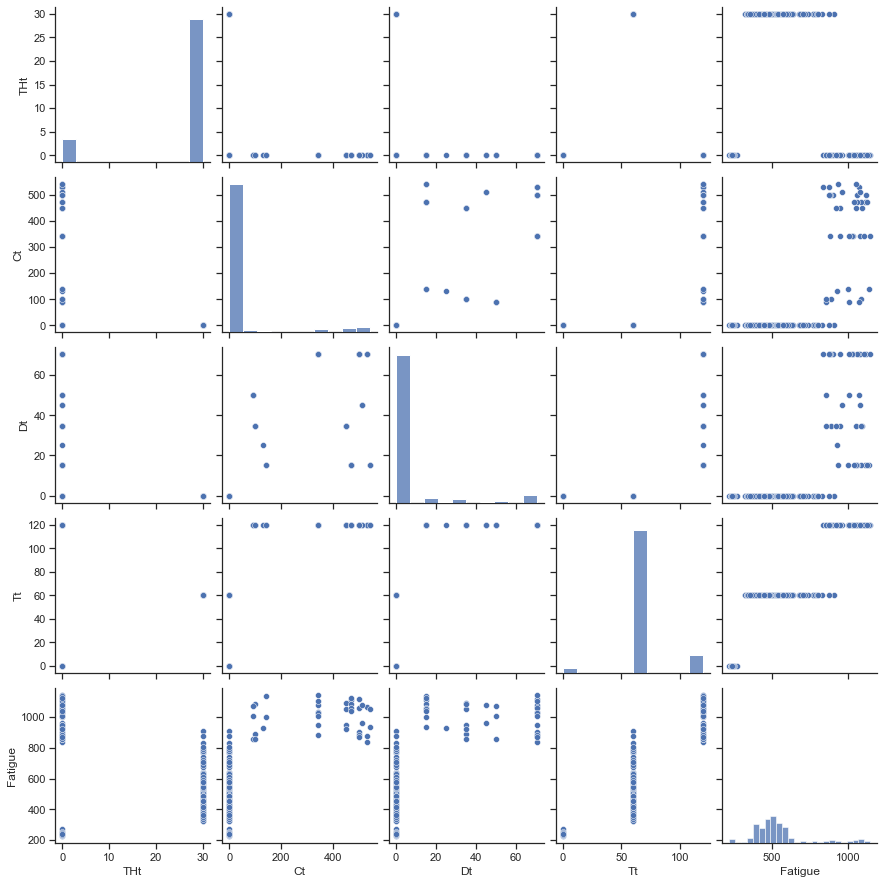

In [39]:
# pairplot
sns.set_theme(style="ticks")
sns.pairplot(data_set2[col_time+['Fatigue']])

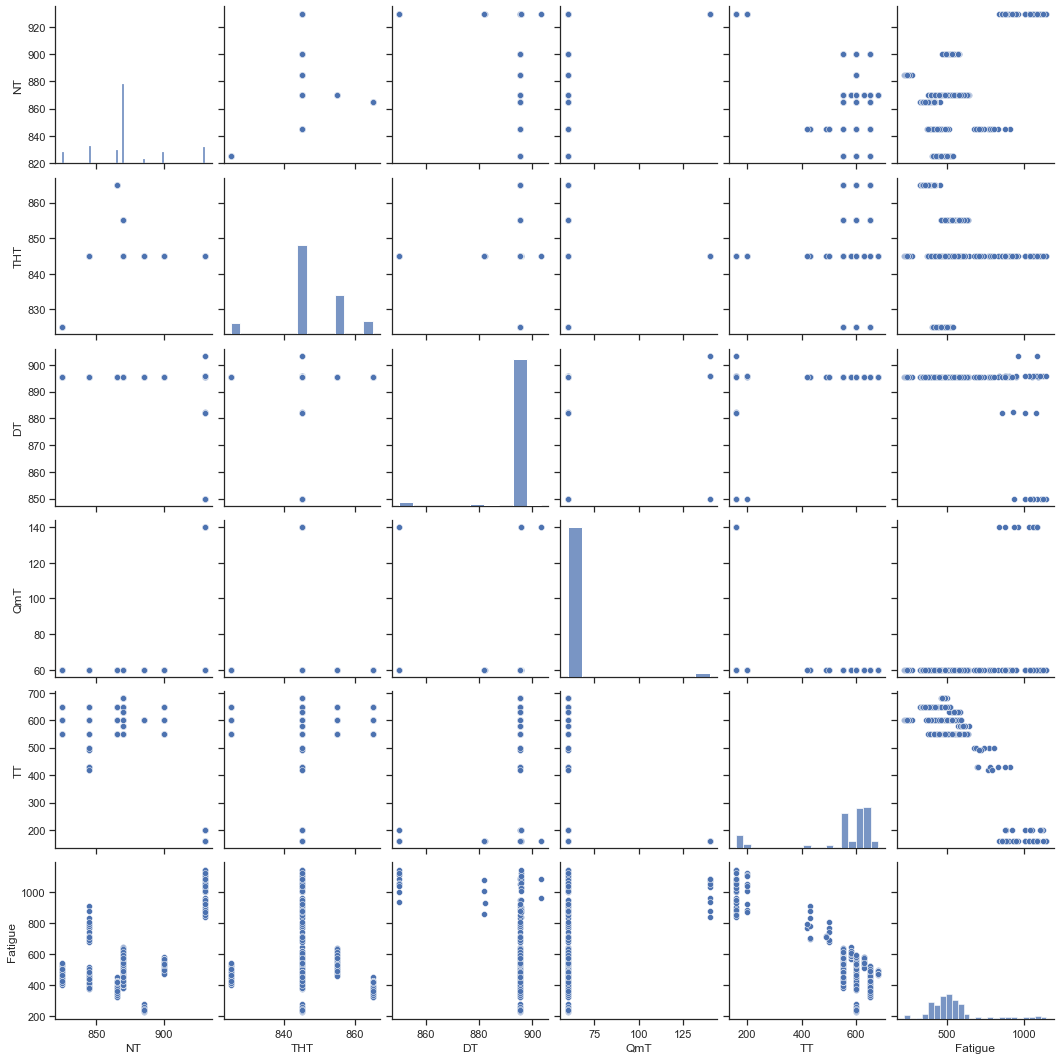

In [40]:
# pairplot
sns.set_theme(style="ticks")
sns.pairplot(data_set2[col_temp2+['Fatigue']])

### 4. Feature Engineering
- Missing values imputation
- Variance Stabilizing Transformations
- Deal with outliers
- Scaling

In [41]:
# Numerical imputation
# set zero for processing time
from feature_engine.imputation import ArbitraryNumberImputer
arbi_imputer = ArbitraryNumberImputer(arbitrary_number=0.0)

# set median for processing temperature and cooling rate
from feature_engine.imputation import MeanMedianImputer
num_imputer = MeanMedianImputer(imputation_method="median")

In [42]:
# Categorical variable - Label encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [43]:
# Variance Stabilizing Transformations
from feature_engine.transformation import YeoJohnsonTransformer
yeo_trans = YeoJohnsonTransformer()

In [44]:
# Deal with outliers
from feature_engine.outliers import Winsorizer
capper = Winsorizer(capping_method="iqr", tail="both")

In [45]:
# Scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### 5. Feature Selection
- Drop Duplicate
- Drop Constant/Quasi constant
- Drop correlated
- Embedded methods

In [46]:
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection, DropDuplicateFeatures

# Drop constant
drop_const = DropConstantFeatures(tol=0.95, missing_values='ignore')

# Drop duplicates
drop_dup = DropDuplicateFeatures()

# Drop correlated
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
drop_corr = SmartCorrelatedSelection(method='pearson', threshold = 0.9,
                                     selection_method='model_performance',
                                     estimator=linreg)

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

ct = ColumnTransformer(
    [("Arbi_imputer", arbi_imputer,  col_time),
     ("Num_imputer",  num_imputer,   col_temp+col_cool),
     ("Encoder",      encoder,       ['Class']),
     ("Yeo_trans",    yeo_trans,     col_chem+col_upstream),
     ("Capper",       capper,        col_chem+col_upstream),
    ],
    
    remainder="passthrough"
  )

preprocessor = make_pipeline(ct,
                     scaler,
                     drop_const,
                     drop_dup,
                     drop_corr
                    )

### 6. Model Selection

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time, math

In [49]:
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Elastic Net', ElasticNet()))
models.append(('SVM', SVR(kernel ='linear', C=10, gamma=0.1, epsilon=0.1)))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('XG Boost',XGBRegressor())) 
#models.append(('LightGBM', LGBMRegressor()))

In [50]:
from sklearn.model_selection import train_test_split
X_train_red, X_val, y_train_red, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [51]:
X_train_red_tr = preprocessor.fit_transform(X_train_red, y_train_red)
X_val_tr = preprocessor.transform(X_val)

In [52]:
# Initialize lists
names = []
train_r2 = []
test_r2 = []
cross_validation_scores = []
runtime = []

# Iterate ofer each element in algorithms
for name, reg in models:
  t1 = time.time()
  names.append(name)
  reg.fit(X_train_red_tr, y_train_red)

  train_r2.append(r2_score(y_train_red, reg.predict(X_train_red_tr)))
  test_r2.append(r2_score(y_val, reg.predict(X_val_tr)))
  
  t2 = time.time()
  runtime.append(t2-t1)

In [53]:
# Create comparison dataframe
model_comparison = pd.DataFrame({'Algorithm': names,
                                 'Train_score': train_r2,
                                 'Test_score': test_r2,
                                 'Runtime': runtime,})

# Sort by Test_RMSE
model_comparison

,Algorithm,Train_score,Test_score,Runtime
0,Linear Regression,0.969995,0.964912,0.015958
1,Elastic Net,0.653578,0.713013,0.006982
2,SVM,0.928445,0.932651,0.010970
3,Decision Tree,0.998725,0.968736,0.004986
4,Random Forest,0.995850,0.983905,0.230391
5,XG Boost,0.998723,0.988164,0.159080


### 7. Model tuning
- XGBoost

In [54]:
parameters = {'xgbregressor__n_estimators': [100, 300, 500],
              'xgbregressor__max_depth': [3, 5],
              'xgbregressor__learning_rate': [0.1, 0.12, 0.15], 
              'xgbregressor__min_child_weight': [0.1, 1],
              }

xgb_reg = XGBRegressor(random_state=0)

full_pipe = make_pipeline(preprocessor,
                          xgb_reg
                         )

grid_search = GridSearchCV(estimator=full_pipe, 
                           param_grid=parameters,
                           scoring='r2',
                           cv=5,
                           return_train_score=True 
                          )

In [55]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('Arbi_imputer',
                                                                                          ArbitraryNumberImputer(arbitrary_number=0.0),
                                                                                          ['THt',
                                                                                           'Ct',
                                                                                           'Dt',
                                                                                           'Tt']),
                                                                                         ('Num_imputer',
             

In [56]:
grid_search.cv_results_['mean_train_score'].mean(), grid_search.cv_results_['mean_test_score'].mean()

(0.9982008764706358, 0.9791210070760701)

In [57]:
grid_search.best_params_

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 3,
 'xgbregressor__min_child_weight': 0.1,
 'xgbregressor__n_estimators': 300}

In [58]:
grid_search.best_score_

0.9800333387007074

In [59]:
# final model 
final_model = grid_search.best_estimator_
y_train_pred  = final_model.predict(X_train)

### 8. Evaluate on test data

In [60]:
y_test_pred = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_test_pred)
final_r2

0.9797562280967317

Text(0, 0.5, 'Predicted Fatigue Strength')

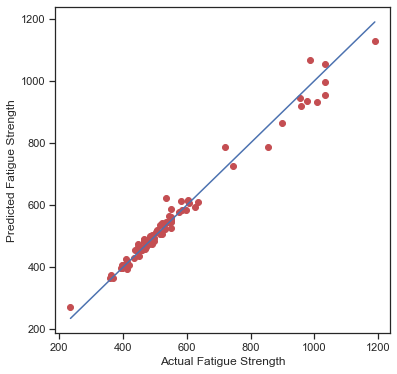

In [61]:
#plot
plt.figure(figsize=(6,6))
    
mx = max(max(y_test),max(y_test_pred))
mi = min(min(y_test),min(y_test_pred))
arr = np.linspace(mi, mx, 20)
plt.plot(arr, arr, c='b')
plt.scatter(y_test, y_test_pred, c='r')
plt.xlabel("Actual Fatigue Strength")
plt.ylabel("Predicted Fatigue Strength")

### 9. Model serving

In [62]:
import pickle
xgb_model_deploy = final_model
xgb_model_deploy.st_dev = mean_squared_error(y_train_pred, y_train) ** 0.5
with open('xgb_model_deploy.pickle', 'wb') as f:
    pickle.dump(xgb_model_deploy, f)